# Reddit Classifier

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import string

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

In [2]:
cars = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/cars_titles.csv')
cooking = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/cooking_titles.csv')
gaming = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/gaming_titles.csv')
movies = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/movies_titles.csv')
political = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/political_titles.csv')
science = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/science_titles.csv')
soccer = pd.read_csv('C:/Users/Acer/PycharmProjects/RedditClassifier/soccer_titles.csv')

In [3]:
titles = pd.concat([cars, cooking, gaming, movies, political, science, soccer])

In [4]:
titles.drop('Unnamed: 0',axis = 1, inplace=True)

In [5]:
titles.sample(5)

,Title,Category
14344,Does anyone know anyone selling a Chevy Corsic...,cars
19370,Right Joystick Not Working Correctly. Has this...,gaming
19794,Need advice on storing tomato sauce,cooking
16698,"[B/R Football] On this day in 2016, Real Madri...",soccer
5261,[El Mundo] Barcelona will have to pay Lionel M...,soccer


In [6]:
titles_categories = titles['Category'].unique()

In [7]:
def generate_text(categories):
    strings = []
    for category in categories:
        text = " ".join(title for title in titles[titles['Category'] == category]['Title'])
        strings.append(text)
    return strings

In [8]:
stopwords = set(STOPWORDS)

In [9]:
def generate_WordCloud():
    clouds = []
    for string in generate_text(titles_categories):
        cloud = WordCloud(stopwords=stopwords).generate(string)
        clouds.append(cloud)
    return clouds

In [10]:
clouds = generate_WordCloud()

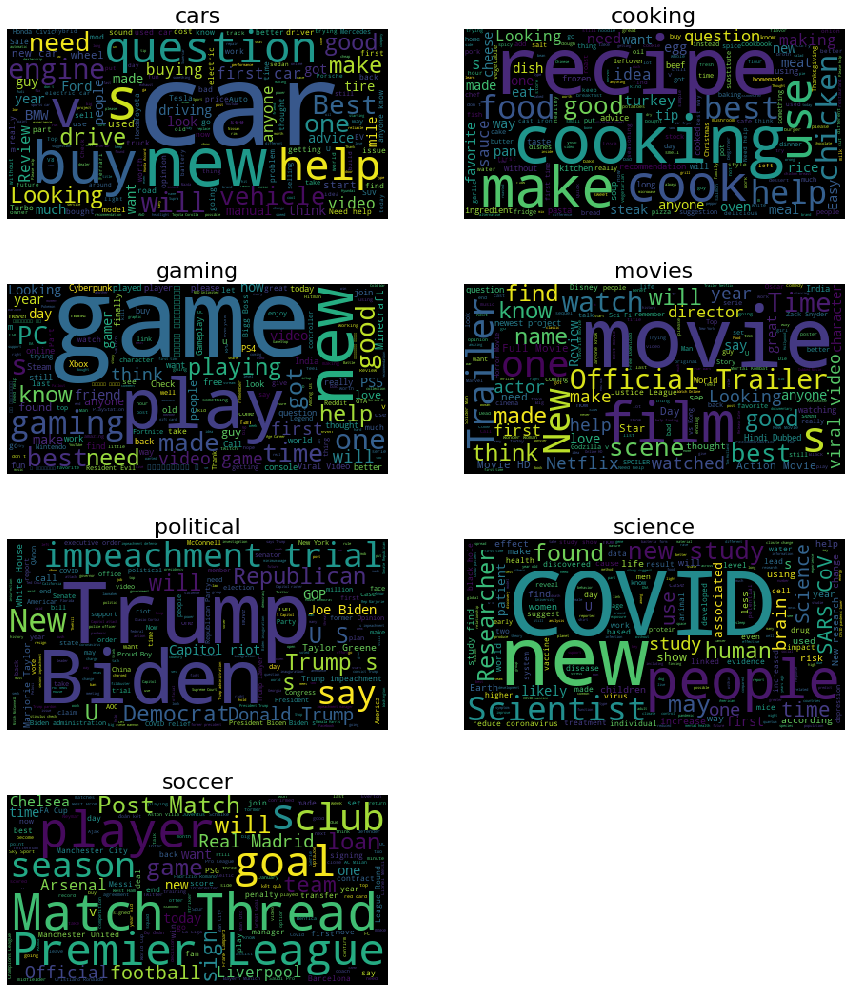

In [11]:
fig = plt.figure(figsize=(15, 18))
for i, cloud in enumerate(clouds):
    fig.add_subplot(4,2,i+1)
    plt.title(titles_categories[i], fontsize = 22)
    plt.axis('off')
    plt.imshow(cloud)
plt.show()

## EDA

In [12]:
missing = titles.isnull().sum()
print('Missing values:\n{}'.format(missing))

Missing values:
Title       0
Category    0
dtype: int64


## Preprocessing

In [13]:
titles['Title'].head(1)

0    Gangster just saying
Name: Title, dtype: object

In [14]:
numbers = [x for x in range(10)]

remove_punctuation = lambda text: text.translate(str.maketrans('','', string.punctuation))
tokenize = lambda text: nltk.word_tokenize(text)
remove_whitespace = lambda text: [x.strip(' ') for x in text]
remove_stopwords = lambda text: ' '.join([word for word in text.split() if word not in stopwords])
remove_numbers = lambda text: ' '.join([word for word in text.split() if not word.isdigit()])

def remove_whitespaces(text):
    text = [x.strip(' ') for x in text]
    return text

def preprocess(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = tokenize(text)
    text = remove_whitespaces(text)
    return text

In [15]:
titles['Title_new'] = titles.Title.apply(preprocess)

In [16]:
titles.head()

,Title,Category,Title_new
0,Gangster just saying,cars,"[gangster, saying]"
1,1 quart motor oil in transmission no choice bu...,cars,"[quart, motor, oil, transmission, choice, driv..."
2,A Hypothetical Car Buying Situation... Need Ad...,cars,"[hypothetical, car, buying, situation, need, a..."
3,What is cash flow statement,cars,"[cash, flow, statement]"
4,Tyres Services,cars,"[tyres, services]"
